U = 1.50V
I = 0.93A

U = 2.00V
I = 0.97A

U = 2.50V
I = 0.95A

U = 3.00V
I = 0.95A

U = 4.00V
I = 1.00A

Odtud a dál, I kolísá mezi 1.06 - 1.09 a 1.12 - 1.16

U = 5.00V
I = 1.08A

U = 6.00V
I = 1.14A

U = 7.00V
I = 1.10A

U = 8.00V
I = 1.12A



In [21]:
import math
# code modified to change negative values to positive ones
def lmap(f,x):
    return list(map(f,x))

def process_raw_decay_data(voltage, startTime = -1, threshold = 0.7, floating_avg = True):
    peaks = []

    # startTime == -1 => auto cutoff
    auto_cutoff = False
    if(startTime == -1):
        auto_cutoff = True
        startTime = 0

    with open(f"./inputs/{voltage}V.csv") as inp:
        lines = inp.read().split("\n")

        startInd = 1
        while (float(lines[startInd].split(",")[0]) < startTime): startInd += 1
        
        hitPeak = False
        startPeak = 0
        endPeak = 0
        for i in range(startInd, len(lines)-1):
            row = lines[i].split(",")

            if (abs(float(row[1])) >= threshold and not hitPeak):
                hitPeak = True
                startPeak = float(row[0])


            if (abs(float(row[1])) < threshold and hitPeak):
                hitPeak = False
                endPeak = float(row[0])

                peaks.append((endPeak+startPeak)/2)                

    results = {}
    interval = 1
    step = 0.1
    curTime = startTime
    x = 0
    while x < len(peaks):
        if (peaks[x] > curTime+interval):
            curTime += step
            x = 0
        elif (peaks[x] > curTime and peaks[x] < curTime+interval):
            if (not curTime in results): results[curTime] = 1
            else: results[curTime] += 1
            
        x += 1

    cutoff_val = math.inf
    if(auto_cutoff):
        cutoff_val = 0

    if(floating_avg):   
        with open(f"./outputs/{voltage}V_PROCESSED_FLOATING_AVERAGE.csv", 'w') as res:
            res.write("t, peaks/s, omega \n")
            for x in range(4, len(results.keys())):
                flAverage = 0
                for y in range(5):
                    flAverage += results[list(results.keys())[x-y]]
                flAverage = flAverage/5

                if(auto_cutoff):
                    if(flAverage > cutoff_val):
                        cutoff_val = flAverage

                if(flAverage < cutoff_val):
                    res.write(str(round(list(results.keys())[x-y], 1)) + "," + str(flAverage) + "," + str(flAverage*2*math.pi/3) + "\n")

        return f"./outputs/{voltage}V_PROCESSED_FLOATING_AVERAGE.csv"
    else:
        with open(f"./outputs/{voltage}V_PROCESSED.csv", 'w') as res:
            res.write("t, peaks/s \n")
            for key in results.keys():
                res.write(str(round(key, 1)) + "," + str(results[key]) + "\n")
        
        return f"./outputs/{voltage}V_PROCESSED.csv"


In [22]:
processed_paths = []
for i in ["1-5", "2", "2-5", "3", "4", "5", "6", "7", "8"]:
    out_path = process_raw_decay_data(i, -1, 0.7, False)
    processed_paths.append(out_path)

# Fitting for $\alpha$, $\gamma$, $c_1$

$$
\omega(t) = - \sqrt{\frac{\alpha}{\gamma}} \tan{(\sqrt{\alpha\gamma}(t+c_1))}
$$

C:\Users\danie\AppData\Local\Temp\ipykernel_17316\1886776742.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


FileNotFoundError: [Errno 2] No such file or directory: './outputs/1-5V_PROCESSED.csv'

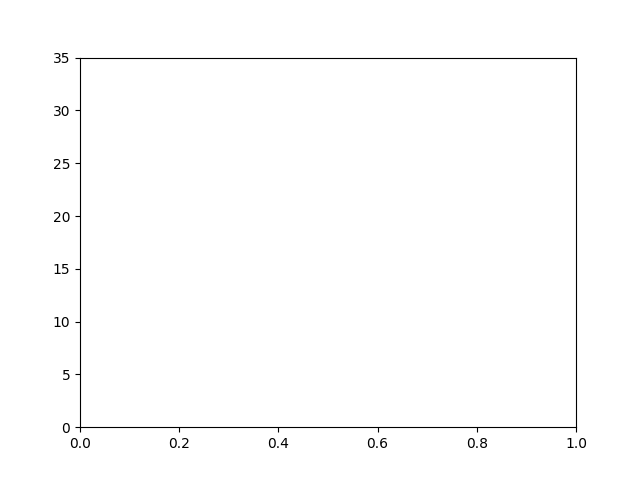

In [23]:
import scipy.optimize as opt
import numpy as np
import matplotlib.pyplot as plt

%matplotlib widget

alphas = []
gammas = []
cs = []
omega_0s = []
R_squares = []

plt.figure()
plt.ylim(0, 35)

for i in range(len(processed_paths)):
    path = processed_paths[i]
    with open(path, "r") as read:
        data = read.readlines()[1:]
        data = lmap(lambda row: row.rstrip().split(","), data)

        xdata = lmap(lambda row: float(row[0]), data)
        ydata = lmap(lambda row: float(row[2]), data)

        omega_0s.append(ydata[0])

        def ω(time, alpha, gamma, c_1):
            return [
                - math.sqrt(alpha / gamma)
                * math.tan(math.sqrt(alpha * gamma) * (t + c_1))
                for t in time
            ]

        [alpha, gamma, c], pcov = opt.curve_fit(
            ω,
            xdata,
            ydata,
            bounds=(
                [0, 0, -math.inf],  # min
                [1, 0.01, 0],  # max
            ),
            p0=[0.21, 0.00025, -170],
            max_nfev=10000
        )
        perr = np.sqrt(np.diag(pcov))

        # calc R^2
        residuals = np.array(ydata) - np.array(ω(xdata, *[alpha, gamma, c]))
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((np.array(ydata) - np.mean(ydata))**2)
        r_squared = 1 - (ss_res / ss_tot)

        alphas.append(alpha)
        gammas.append(gamma)
        cs.append(c)
        R_squares.append(r_squared)


        plt.plot(xdata, ydata, label="Measurement")
        plt.xlabel("t [s]")
        plt.ylabel("ω [rad/s]")

        # plt.xticks(np.arange(min(xdata), max(xdata) + 1, 20.0))
        # plt.yticks(np.arange(min(ydata), max(ydata) + 1, 10.0))

        # plt.title(f"Spinner {i+1} decay rate")
        # plt.text(max(xdata) * 0.8, max(ydata) * 0.7, f"α={alpha:.3f}\nγ={gamma:.6f}\nc1={c:.1f}\n\nR^2={r_squared:.5f}")

        plt.legend()
